# Mining my AutoSleep Data


In [1]:
import pandas as pd
import numpy as np 


# First we need to import our data from a csv file: 
df = pd.read_csv("AutoSleep.csv", header=0)
days_df = pd.read_csv("days_of_week.csv", header=0)

df_2 = pd.read_csv("AutoSleep_part2.csv", header=0)
days_part_2 = pd.read_csv("days_test.csv", header=0)
join = [df, df_2]
join_days = [days_df, days_part_2]

df = pd.concat(join)
days_df = pd.concat(join_days)

## Explore the Data & Handle Missing Values
* With this dataset, it appears that the nights I wasn't wearing my watch were not recorded so there are no missing values
* There are, however, `np.NaN` values in the columns tracking blood oxygen levels because my Apple Watch doesn't have that capability. 
    * Since this data is missing throughout the entire time interval of the dataset, I will be deleting those rows from the dataframe.
* This is nice except when I want to compare it so another source of data, it will be a little more difficult to combine 
without filling in the missing dates on the autosleep data or removing those dates from the other dataset. 


In [2]:
# What are the column names?
# print(df.columns)

# print(df.head(5))
# print(df.tail(5))

# this for loop returns true if a column has any null values
for col in df:
    check_for_nan = df[col].isnull().values.any()
    if check_for_nan == True:
        # print (col, check_for_nan, df[col].isnull().count())
        df.drop(col, axis=1, inplace=True)

df.drop(['ISO8601', 'toDate', 'inBed',
       'awake', 'fellAsleepIn', 'sessions', 'asleepAvg7', 'efficiencyAvg7', 
       'qualityAvg7', 'sleepBPMAvg7', 'wakingBPMAvg7','hrvAvg7'], axis=1, inplace=True)



The following Columns have missing values for every instance in the dataset:
* deep 
* deepAvg7 
* dayBPM 
* dayBPMAvg7 
* SpO2Avg 
* SpO2Min 
* SpO2Max 
* respAvg 
* respMin 
* respMax 
* tags 
* notes 

## Now for some Summary Statistics: 
* Summarize the following into a pandas Series:
    * `nights_total` = total number nights logged
    * `avg_sleep` = average sleep 
    * `avg_[day]` = average sleep for each day of the week
    * `std_sleep` = standard deviation of sleep 
    * `std_[day]` = standard deviation for each day of the week
    * `mode_hours` = most common sleep length (rounded to the nearest hour)
    * `mode_day` = most common day of the week when mode sleep length occurred


In [7]:
# collecting summary statistics:
import utils 
import importlib
importlib.reload(utils)

summary_stats = []

merged_df = days_df.merge(df, on='fromDate')
merged_df.head()

# 1. total number of nights logged
nights_total = df.shape[0]
summary_stats.append(['nights total' ,nights_total])

# 2. average hours slept
# we need to convert the timestamps into numeric values before we can calculate the mean
merged_df = utils.clean_sleep(merged_df, "asleep")
sleep_ser = merged_df["asleep"]   
avg_sleep_secs = sleep_ser.mean()
avg_sleep = utils.sec_to_hours(avg_sleep_secs)
median_sleep_secs = sleep_ser.median()
median_sleep = utils.sec_to_hours(median_sleep_secs)
# print("average time slept:", avg_sleep, "median:", median_sleep)
summary_stats.append(['average sleep', avg_sleep])
summary_stats.append(['median sleep', median_sleep])


grouped_by_day = merged_df.groupby('Day')
# SPLIT: 
monday_df = grouped_by_day.get_group("Monday")
tuesday_df = grouped_by_day.get_group("Tuesday")
wednesday_df = grouped_by_day.get_group("Wednesday")
thursday_df = grouped_by_day.get_group("Thursday")
friday_df = grouped_by_day.get_group("Friday")
saturday_df = grouped_by_day.get_group("Saturday")
sunday_df = grouped_by_day.get_group("Sunday")

# APPLY & COMBINE: 
# 3. average sleep for each day of the week
avg_sleep_per_day = pd.DataFrame([['monday', utils.sec_to_hours(monday_df['asleep'].mean())], 
                                  ['tuesday',utils.sec_to_hours(tuesday_df['asleep'].mean())],
                                  ['wednesday',utils.sec_to_hours(wednesday_df['asleep'].mean())],
                                  ['thursday',utils.sec_to_hours(thursday_df['asleep'].mean())],
                                  ['friday',utils.sec_to_hours(friday_df['asleep'].mean())],
                                  ['saturday',utils.sec_to_hours(saturday_df['asleep'].mean())],
                                  ['sunday',utils.sec_to_hours(sunday_df['asleep'].mean())]], 
                                  columns=['day', 'asleep'])
# avg_sleep_per_day


# 4. standard deviation of sleep
std_sleep = utils.sec_to_hours(sleep_ser.std())
summary_stats.append(['sleep std', std_sleep])


# 6. most common sleep length rounded to the nearest hour
ser = sleep_ser.copy()
for i in range(len(sleep_ser)):
    hours = round(sleep_ser[i]/3600, 0)
    ser[i] = hours
mode_hours = ser.mode()  # 8.78 is about 8 hours and 45 minutes! 
summary_stats.append(['sleep mode', mode_hours.iloc[0]])



summary_df = pd.DataFrame(summary_stats, columns=['metric', 'value'])
# summary_df

,metric,value
0,nights total,61
1,average sleep,[7.0 hours 16.0 mins 7.868852459017944 seconds]
2,median sleep,[7.0 hours 28.0 mins 0.0 seconds]
3,sleep std,[1.0 hours 58.0 mins 35.54193643606686 seconds]
4,sleep mode,7.0


### Plotting Some of the Data:

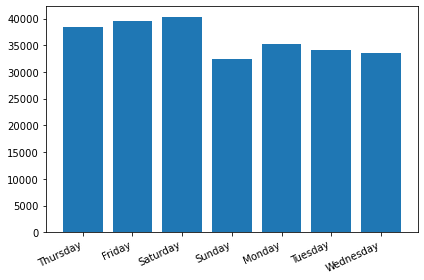

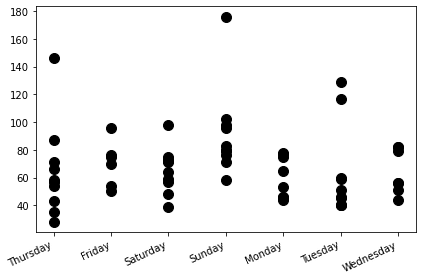

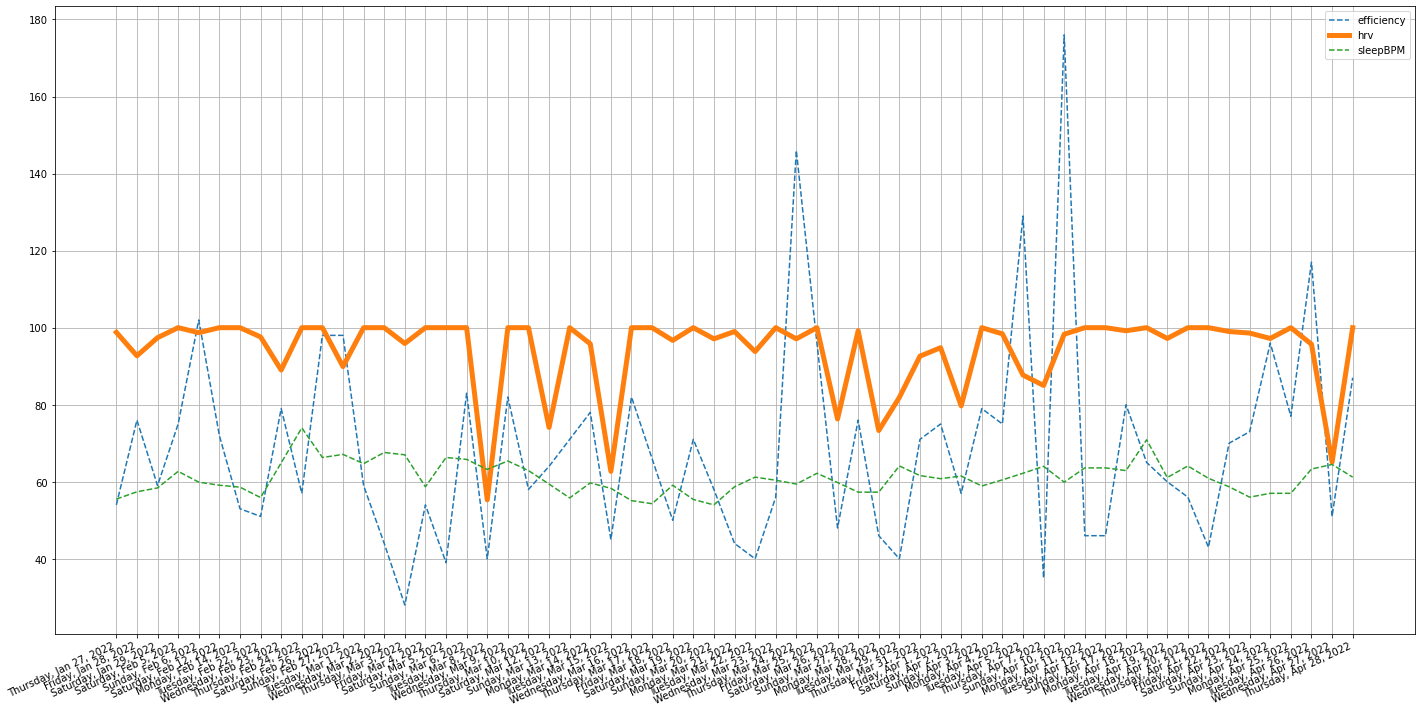

In [4]:
import matplotlib.pyplot as plt


utils.bar_graph_example(merged_df['Day'], merged_df['asleep'])

utils.scatter_chart_example(merged_df['Day'], merged_df['hrv'])

utils.line_chart_example(merged_df['fromDate'], merged_df['efficiency'], merged_df['hrv'], merged_df['sleepBPM'],
                        "efficiency", "hrv", "sleepBPM")


